# Meteorological conditions during SSW events

In [1]:
import xarray as xr
import xarray.ufuncs as xrf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob

## Definition of functions

In [2]:
def read_group(gruppe,loc):
    station = loc #ersten Buchstaben bitte bitte groß schreiben
    
    if loc=='Rio':
        timestart = '2008-02-01'
        timeend = '2019-12-31'
    elif loc == 'Col':
        timestart =  '2004-08-01'
        timeend =  '2019-03-06'
    elif loc=='CMA':
        timestart = '2002-01-01'
        timeend = '2018-12-31'
    elif loc=='Dav':
        timestart = '2005-01-01'
        timeend ='2019-12-31'
    elif loc=='Kir':
        timestart = '1999-08-01'
        timeend ='2019-12-31'
    
    infiles = f'{root_path}{station}/Meteor_radar_{station}_GW_*.h5'
    if gruppe == 'tides':
        ds = xr.open_mfdataset(infiles, concat_dim = 'phony_dim_4', group = gruppe, combine='nested', parallel = True)
        ds = ds.rename({'phony_dim_4': 'time', 'phony_dim_5': 'alt'})
    else:
        ds = xr.open_mfdataset(infiles, concat_dim = 'phony_dim_6', group = gruppe, combine='nested', parallel = True)
        ds = ds.rename({'phony_dim_6': 'time', 'phony_dim_7': 'alt'})
    ds['alt'] = alt
    ds['alt'].attrs['units'] = 'km'
    # change time range according to meteor radar station
    ds['time'] = pd.date_range(start = timestart, end = timeend, periods = ds.time.shape[0]) 
    return ds

In [3]:
def read_var(gruppe, var):
        varout = gruppe[var]
        return varout

In [4]:
def hwind(u,v):
    return np.sqrt(u**2+v**2)

In [5]:
def time_mean(step,var):
    return var.resample(time='1'+step).mean('time') #Immer nur D oder M oder H oder Y eintragen! Mit Anführungszeichen!

In [6]:
def anomalie(step,var):
    string = "time."+step   
    climatology = var.groupby(string).mean("time")
    anomalies = var.groupby(string) - climatology
    
    return anomalies

In [7]:
def grav_waves(wind_component,loc): # Beides muss schon als String reingegeben werden! 
    ds = read_group('wind',loc)
    gw = read_var(ds,wind_component) - read_var(ds,wind_component+'_fil')
    return gw

In [8]:
def grav_waves_gaia(wind_component,loc_array): # Windkomponente muss schon als String reingegeben werden! 
    gw = read_var(loc_array,wind_component) - read_var(loc_array,wind_component+'_fil')
    return gw

In [9]:
def kin_energy_grav_waves(loc):
    kin_energy = 0.5*((grav_waves('u',loc))**2 + (grav_waves('v',loc))**2)
    return kin_energy

In [10]:
def kin_energy_grav_waves_gaia(loc_array):
    kin_energy = 0.5*((grav_waves_gaia('u',loc_array))**2 + (grav_waves_gaia('v',loc_array))**2)
    return kin_energy

#### Superposed Epoch Analysis

In [11]:
def sea(days_period,station,var):
    df_dates = pd.read_csv('ssw_dates_displ_'+station+'.csv') # you can load SSWs from a csv file like attached
    dates = df_dates.set_index('BeginDate')

    xa_ls = []
    max_lag = days_period
    for il, days in enumerate(range(-max_lag,max_lag+1)):  
        sel_dates = pd.to_datetime(dates.index) + pd.Timedelta(str(days)+' days')
        mask = np.in1d(var.time.dt.floor('1D'),sel_dates)
        comp_m = var.sel(time = mask).mean('time')
        xa_ls.append(comp_m)
   
    xa_comp = xr.concat(xa_ls, dim = 'days')
    xa_comp['days'] = range(-max_lag, max_lag+1)

    # print(xa_comp)
    return xa_comp

## SSW-Events

In [12]:
ssw_events = ['2008-02-21','2009-01-23','2010-01-26','2010-02-09','2010-03-24','2011-02-01','2011-03-25','2012-01-17','2013-01-06','2013-01-17','2014-03-31','2015-01-05','2016-03-16','2018-02-12']

In [13]:
alt = [70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, \
       106, 108, 110, 112, 114, 116, 118, 120]
root_path = '/home/gemeinsam_tmp/UA_students/data/'
#xr.open_dataset( '/home/gemeinsam_tmp/UA_students/data/Kir/Meteor_radar_Kir_GW_201912.h5', group='info')['day']

## Measurements

### Wind

#### Collm

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 31 times more chunks
  return self.array[key]
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


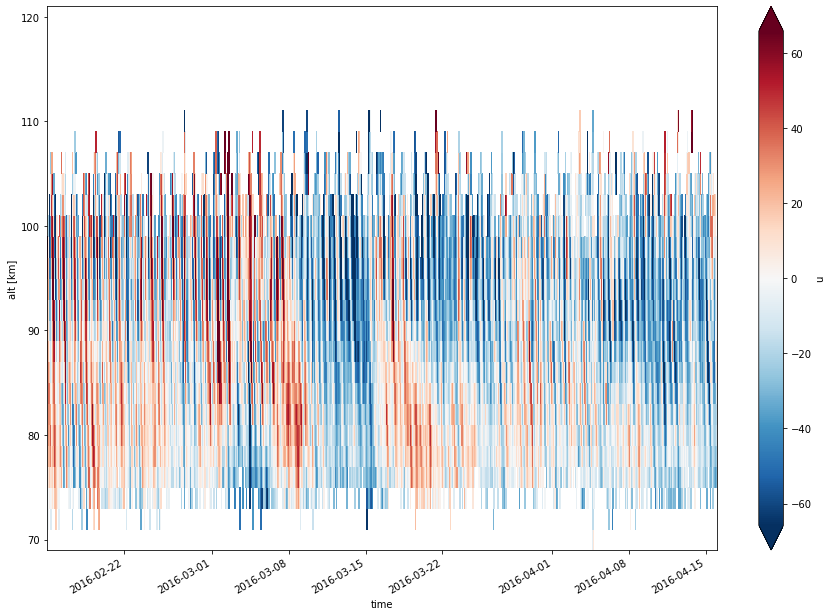

In [14]:
ds_col = read_group('wind','Col')
u_col = read_var(ds_col,'u')
v_col = read_var(ds_col,'v')

u_col_anomalie = anomalie('hour',u_col)
# u_col_anomalie.plot(x='time',robust=True)

v_col_anomalie = anomalie('day',v_col)

sea_u_col = sea(30,'Col',u_col)
sea_u_col_anomalie = sea(30,'Col',u_col_anomalie)

sea_v_col = sea(30,'Col',v_col)
sea_v_col_anomalie = sea(30,'Col',v_col_anomalie)

u_col_anomalie.sel(time=slice('2016-02-15', '2016-04-15')).plot(x='time',size=10,robust=True)

##### Climatology of u-component

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


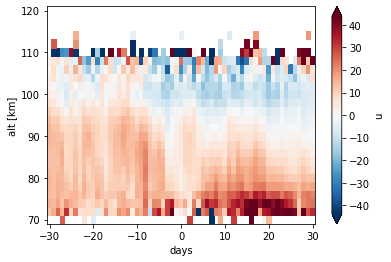

In [15]:
sea_u_col.plot(x='days',robust=True)

##### Anomalies of u-component

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


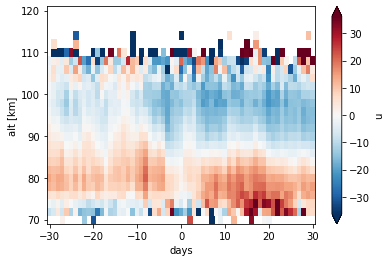

In [16]:
sea_u_col_anomalie.plot(x='days',robust=True)

##### Interpretation:
In the time from 3 weeks until 1 week before the SSW the zonal wind is more western (eastward) than normal (in the mean for the certain alendar day). This maybe could be the upper edge or the upward propagation of the intensified jetsream between stratosphere and mesosphere which is typical in the time before SSW's --> Validate that with GAIA model data (check whether the jetstream really reaches this high altitudes!!!)

Some days before the onset of the SSW's the zonal wind becomes less western (eastward) and maybe even a weak eastern (westward) component. This wind drop is typical for the SSW onset as the polar vortex and the jet collapse.

In the month after the SSW we see in the altitudes between 70 and 80 km a very strong increase in the u-component of the wind as well as in the anomalies. That could correspond to the re-establishment of the stratopause which often takes place in this height some weeks after an SSW event. --> Also validate with GAIA model data!!!

In the altitudes from 90 to 100 km the zonal wind becomes more eastern (westward) with the beginning of the SSW and already around one week before the onset.

##### Climatology of v-component

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


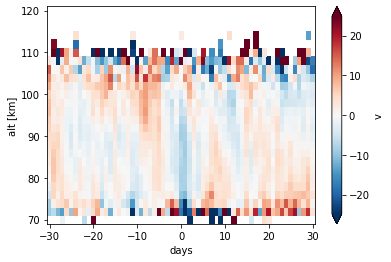

In [17]:
sea_v_col.plot(x='days',robust=True)

##### Anomalies of v-component

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


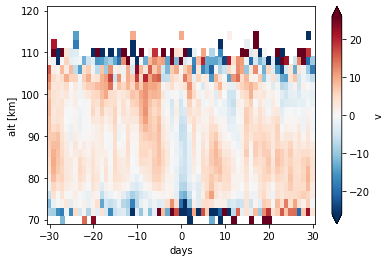

In [18]:
sea_v_col_anomalie.plot(x='days',robust=True)

##### Interpretation:
On the day of the SSW onset we see a change in the meridional wind direction from southern (northward) to northern (southward). After the SSW onset it returns to the values like before the SSW nearly immediately. Check for a signature in the v-component of gravity waves! If there is none, then the reason may be planetary waves which are typically most well pronounced around the SSW onset as their upward propagation and breaking initiates the SSW events.

#### CMA Canadian Meteor Orbit Radar (CMOR) (London, Ontario - Canada)

In [19]:
ds_cma = read_group('wind','CMA')
u_cma = read_var(ds_cma,'u')  
v_cma = read_var(ds_cma,'v')

u_cma_anomalie = anomalie('day',u_cma)
# u_cma_anomalie.plot(x='time',robust=True)

v_cma_anomalie = anomalie('day',v_cma)

sea_u_cma = sea(30,'CMA',u_cma)
sea_u_cma_anomalie = sea(30,'CMA',u_cma_anomalie)

sea_v_cma = sea(30,'CMA',v_cma)
sea_v_cma_anomalie = sea(30,'CMA',v_cma_anomalie)

##### Climatology of u-component

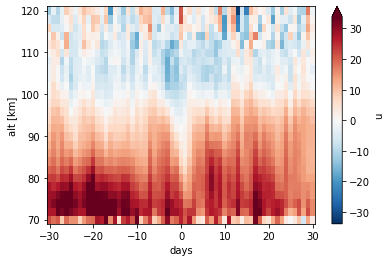

In [20]:
sea_u_cma.plot(x='days',robust=True)

##### Anomalies of u-component

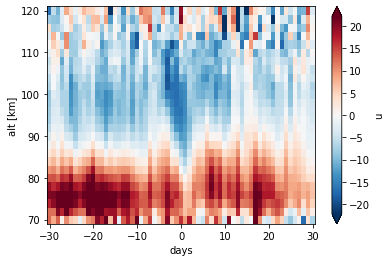

In [21]:
sea_u_cma_anomalie.plot(x='days',robust=True)

##### Interpretation:
The decrease of the western (eastward) component in 70 to 80 km is not as well pronounced as at Collm. But in higher altitudes between 90 and 110 km we see around 4-5 days before the SSW onset the zonal wind becoming more easterly (westward). Especially the anomalies show that, whose signature descends in altitude witth propagating time.
--> Reason? --> Check for a signature in gravity waves --> if not ---> probably planetary waves

##### Climatology of v-component

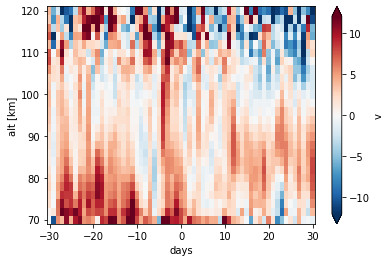

In [22]:
sea_v_cma.plot(x='days',robust=True)

##### Anomalies of v-component

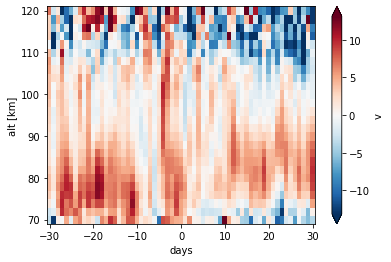

In [23]:
sea_v_cma_anomalie.plot(x='days',robust=True)

##### Interpretation:
At CMA the v-component shows a strong increase and positive anomaly in the mesosphere around a week before the SSW onset. The reason seems to be that around 10 - 7 days before the SSW onset and during the 10 days after the SSW onset the western wind is much weaker and at some point already turns to a weak eastern component.
---> Reason? --> same procedure as at Collm!

#### Davis (Antarctic)

In [24]:
ds_dav = read_group('wind','Dav')
u_dav = read_var(ds_dav,'u')  
v_dav = read_var(ds_dav,'v')

u_dav_anomalie = anomalie('day',u_dav)
# u_rio_anomalie.plot(x='time',robust=True)

v_dav_anomalie = anomalie('day',v_dav)

sea_u_dav = sea(30,'Dav',u_dav)
sea_u_dav_anomalie = sea(30,'Dav',u_dav_anomalie)

sea_v_dav = sea(30,'Dav',v_dav)
sea_v_dav_anomalie = sea(30,'Dav',v_dav_anomalie)

##### Climatology of u-component

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


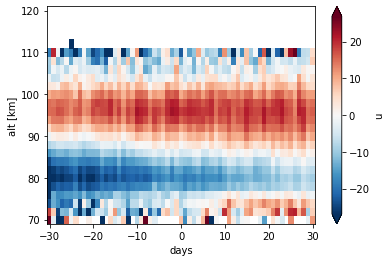

In [25]:
sea_u_dav.plot(x='days',robust=True)

##### Anomalies of u-component

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


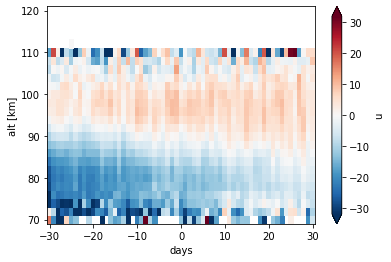

In [26]:
sea_u_dav_anomalie.plot(x='days',robust=True)

##### Climatology of v-component

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


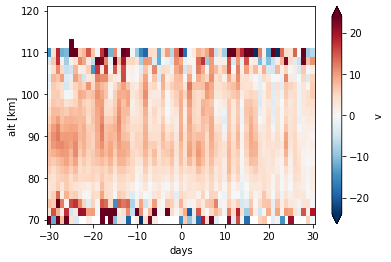

In [27]:
sea_v_dav.plot(x='days',robust=True)

##### Anomalies of v-component

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


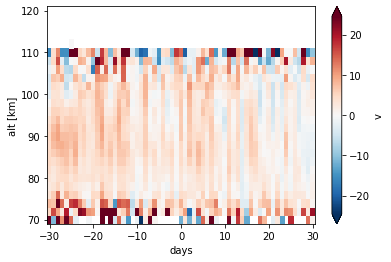

In [28]:
sea_v_dav_anomalie.plot(x='days',robust=True)

##### Interpretation:
Davis shows the least changes of the 5 stations. This seems logic as it is situated in the Antarctic and therefore os the southernmost station with the greatest distance to the northern hemispheric polar vortex where the SSW events occur.

#### Rio Grande

In [29]:
ds_rio = read_group('wind','Rio')
u_rio = read_var(ds_rio,'u')  
v_rio = read_var(ds_rio,'v')

u_rio_anomalie = anomalie('day',u_rio)
# u_rio_anomalie.plot(x='time',robust=True)

v_rio_anomalie = anomalie('day',v_rio)

sea_u_rio = sea(30,'Rio',u_rio)
sea_u_rio_anomalie = sea(30,'Rio',u_rio_anomalie)

sea_v_rio = sea(30,'Rio',v_rio)
sea_v_rio_anomalie = sea(30,'Rio',v_rio_anomalie)

##### Climatology of u-component

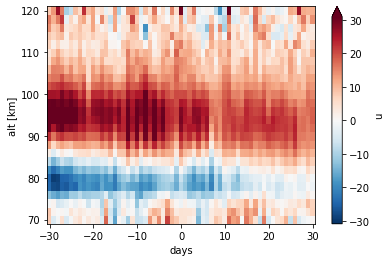

In [30]:
sea_u_rio.plot(x='days',robust=True)

##### Anomalies of u-component

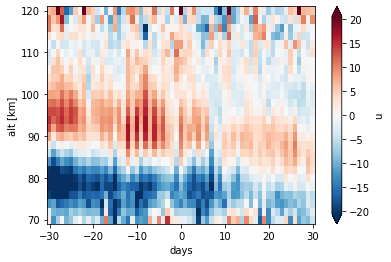

In [31]:
sea_u_rio_anomalie.plot(x='days',robust=True)

##### Climatology of v-component

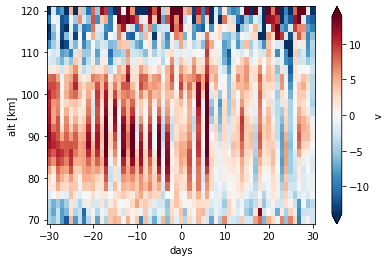

In [32]:
sea_v_rio.plot(x='days',robust=True)

##### Anomalies of v-component

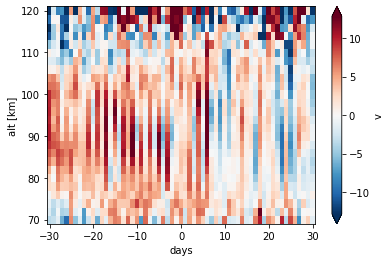

In [33]:
sea_v_rio_anomalie.plot(x='days',robust=True)

##### Interpretation:
Also not so much or not so well structured changes becase it is on the summer hemisphere, too. (Argentina)

#### Kiruna, Norrbotten (Sweden)

In [34]:
ds_kir = read_group('wind','Kir')
u_kir = read_var(ds_kir,'u')  
v_kir = read_var(ds_kir,'v')

u_kir_anomalie = anomalie('day',u_kir)
# u_rio_anomalie.plot(x='time',robust=True)

v_kir_anomalie = anomalie('day',v_kir)

sea_u_kir = sea(30,'Kir',u_kir)
sea_u_kir_anomalie = sea(30,'Kir',u_kir_anomalie)

sea_v_kir = sea(30,'Kir',v_kir)
sea_v_kir_anomalie = sea(30,'Kir',v_kir_anomalie)

##### Climatology of u-component

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


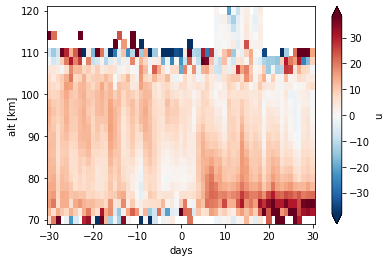

In [35]:
sea_u_kir.plot(x='days',robust=True)

##### Anomalies of u-component

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


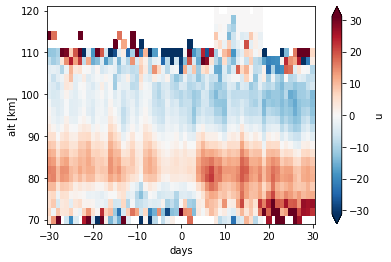

In [36]:
sea_u_kir_anomalie.plot(x='days',robust=True)

##### Interpreation:
Kiruna in northern Sweden is our northernmost station and quite similar to Collm. The strong increase of the western (eastward) wind at 70 km (probably due to elevated stratopause) is well pronounced at around 20-30 days after the SSW onset.

##### Climatology of v-component

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


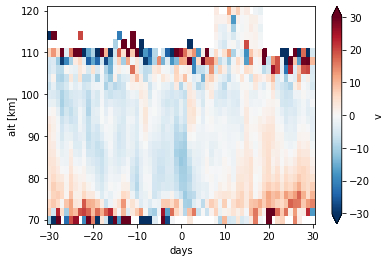

In [37]:
sea_v_kir.plot(x='days',robust=True)

##### Anomalies of v-component

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


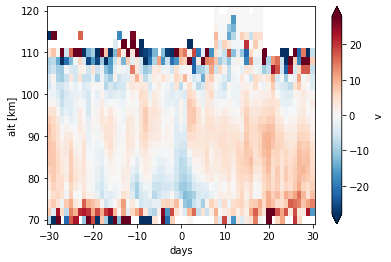

In [38]:
sea_v_kir_anomalie.plot(x='days',robust=True)

##### Interpretation:
Also quite similar to Collm. The negative anomalies and the increasing northern (southward) direction of the meridional wind component are spread wider concerning time than at Collm observatory. They begin around 2-3 days before the onset of the SSW's and last until 2-3 days after it as well.

### Gravity waves

#### Collm

In [39]:
gw_u_col = grav_waves('u','Col')
gw_v_col = grav_waves('v','Col')
# gw_total_energy_neu_col = 0.5*(gw_u_col**2 + gw_v_col**2)
gw_total_energy_col = kin_energy_grav_waves('Col')

sea_gw_u_col = sea(60,'Col',gw_u_col)
sea_gw_v_col = sea(60,'Col',gw_v_col)

# sea_gw_total_energy_neu_col = sea(60,'Col',gw_total_energy_neu_col)
sea_gw_total_energy_col = sea(60,'Col',gw_total_energy_col)


gw_total_energy_col_anomalie = anomalie('day',gw_total_energy_col)
gw_u_col_anomalie = anomalie('day',gw_u_col)
gw_v_col_anomalie = anomalie('day',gw_v_col)


sea_gw_total_energy_col_anomalie = sea(60,'Col',gw_total_energy_col_anomalie)
sea_gw_u_col_anomalie = sea(60,'Col',gw_u_col_anomalie)
sea_gw_v_col_anomalie = sea(60,'Col',gw_v_col_anomalie)

##### u-component of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


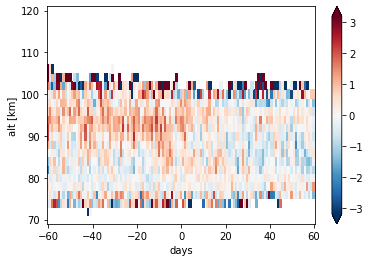

In [40]:
sea_gw_u_col.plot(x='days',robust=True)

##### Anomalies of the u-component of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


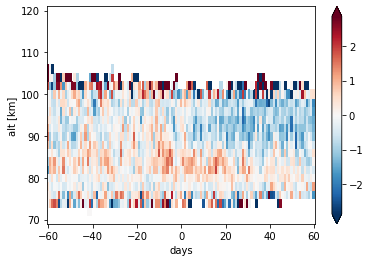

In [41]:
sea_gw_u_col_anomalie.plot(x='days',robust=True)

##### v-component of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


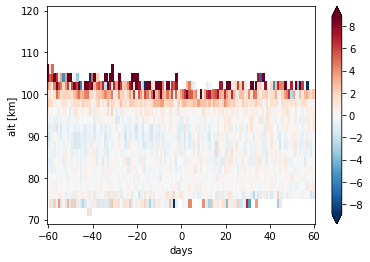

In [42]:
sea_gw_v_col.plot(x='days',robust=True)

##### Anomalies of the v-component of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


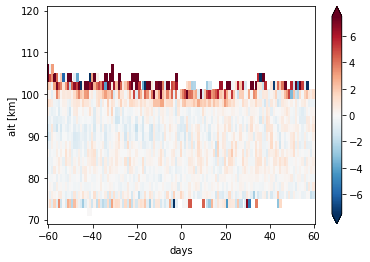

In [43]:
sea_gw_v_col_anomalie.plot(x='days',robust=True)

##### Total kinetic energy of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


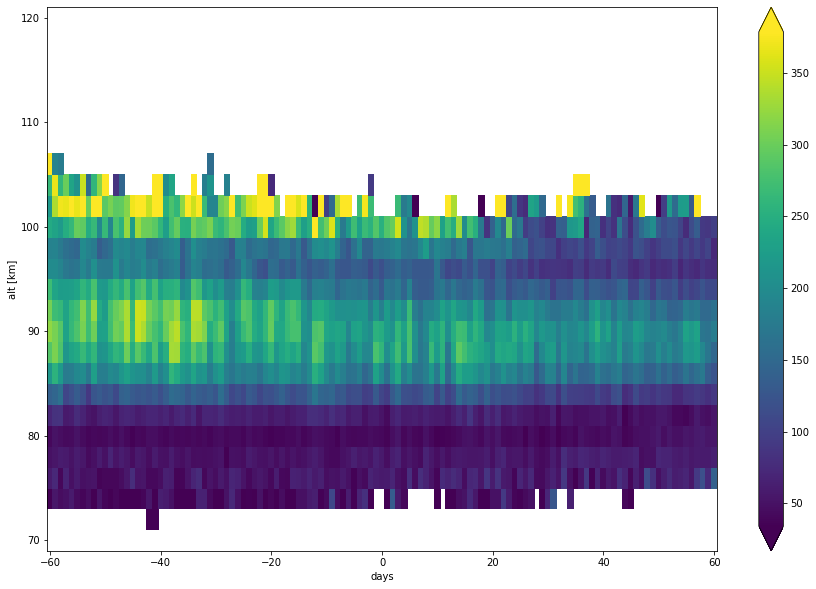

In [44]:
sea_gw_total_energy_col.plot(x='days',size=10,robust=True)

Observation: After the onset of the SSW the kinetic enrgy of the gravity waves shows a slight decrease. This would mean that around and after SSW's less or at least weaker gravity waves are present in the Mesosphere. Especially the zonal component shows this decrease as well.

Notiz: Vielleicht aber nur die Energie zeigen und nicht noch die einzelnen Komponenten - das wird sonst zu viel... --> Nein! Auf jeden Fall mindestens einmal die Unterscheidung machen, um zu zeigen welche Komponente dominiert und auch welche Richtung sie aufzeigt (Ost oder West)!!!

##### Anomalies of the total kinetic energy of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


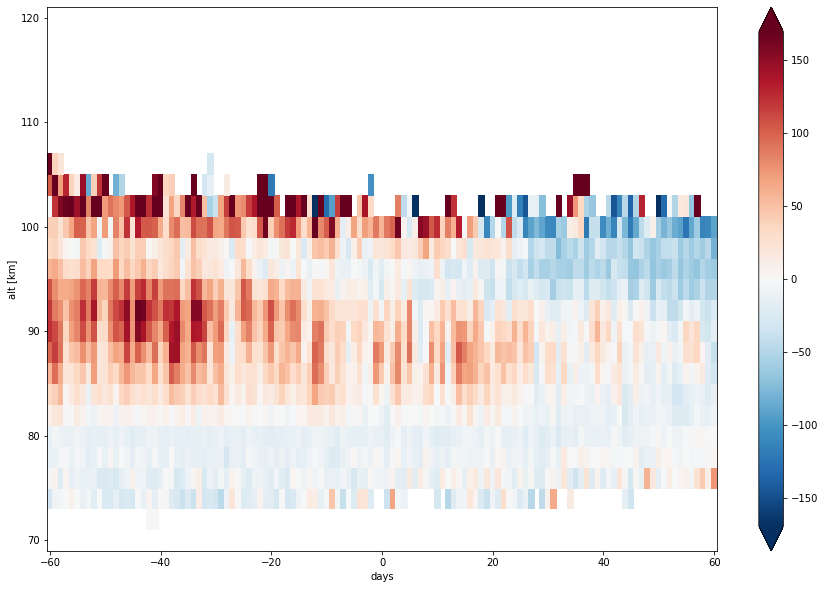

In [45]:
sea_gw_total_energy_col_anomalie.plot(x='days',size=10,robust=True)

#### Rio Grande

In [46]:
gw_total_energy_rio = kin_energy_grav_waves('Rio')

sea_gw_total_energy_rio = sea(60,'Rio',gw_total_energy_rio)


gw_total_energy_rio_anomalie = anomalie('day',gw_total_energy_rio)

sea_gw_total_energy_rio_anomalie = sea(60,'Rio',gw_total_energy_rio_anomalie)


gw_u_rio = grav_waves('u','Rio')
gw_v_rio = grav_waves('v','Rio')

sea_gw_u_rio = sea(60,'Rio',gw_u_rio)
sea_gw_v_rio = sea(60,'Rio',gw_v_rio)

gw_u_rio_anomalie = anomalie('day',gw_u_rio)
gw_v_rio_anomalie = anomalie('day',gw_v_rio)

sea_gw_u_rio_anomalie = sea(60,'Rio',gw_u_rio_anomalie)
sea_gw_v_rio_anomalie = sea(60,'Rio',gw_v_rio_anomalie)

##### u-component of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


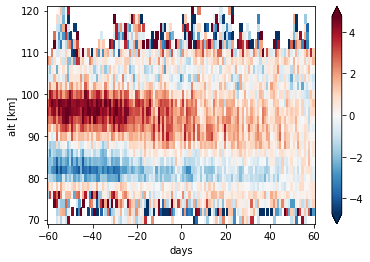

In [47]:
sea_gw_u_rio.plot(x='days',robust=True)

##### Anomalies of the u-component of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


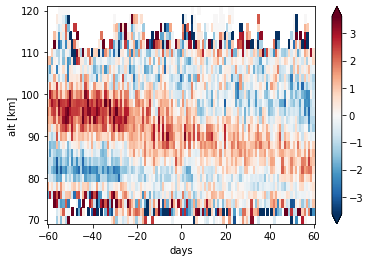

In [48]:
sea_gw_u_rio_anomalie.plot(x='days',robust=True)

##### v-component of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


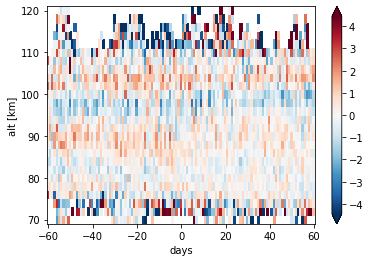

In [49]:
sea_gw_v_rio.plot(x='days',robust=True)

##### Anomalies of the v-component of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


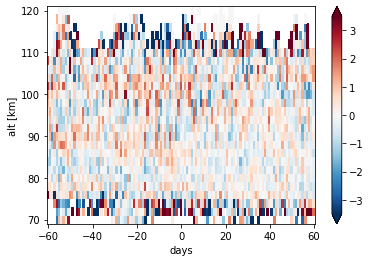

In [50]:
sea_gw_v_rio_anomalie.plot(x='days',robust=True)

##### Total kinetic energy of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


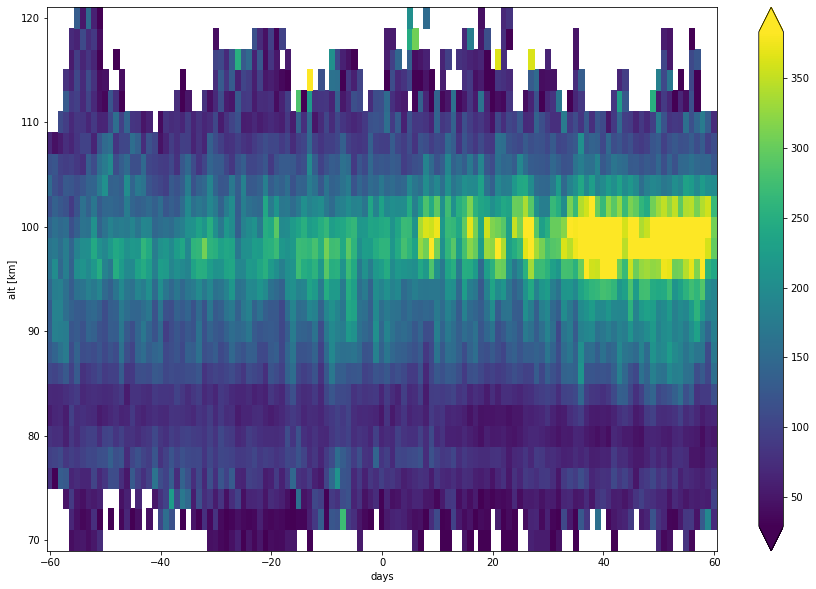

In [51]:
sea_gw_total_energy_rio.plot(x='days',size=10,robust=True)

##### Anomalies of the total kinetic energy of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


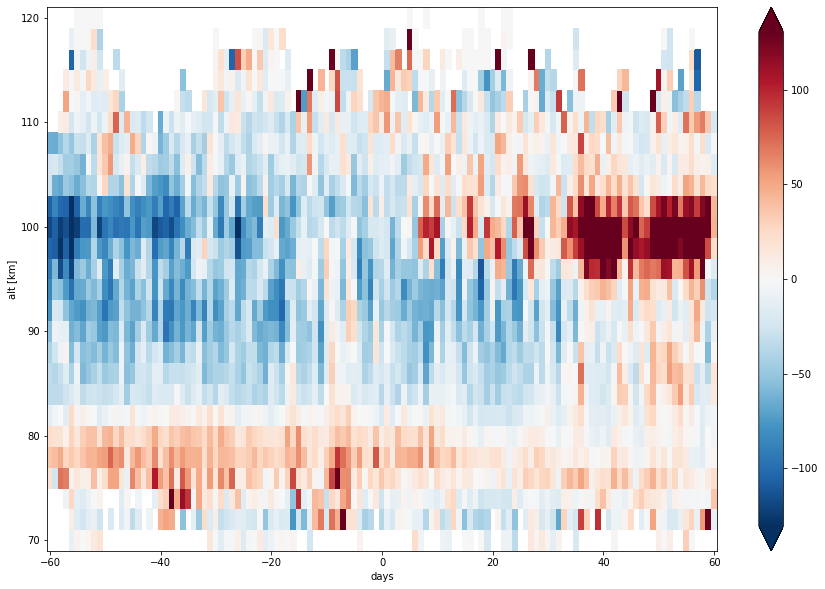

In [52]:
sea_gw_total_energy_rio_anomalie.plot(x='days',size=10,robust=True)

#### CMA Canadian Meteor Orbit Radar (CMOR) (London, Ontario - Canada)

In [53]:
gw_total_energy_cma = kin_energy_grav_waves('CMA')

sea_gw_total_energy_cma = sea(60,'CMA',gw_total_energy_cma)


gw_total_energy_cma_anomalie = anomalie('day',gw_total_energy_cma)

sea_gw_total_energy_cma_anomalie = sea(60,'CMA',gw_total_energy_cma_anomalie)


gw_u_cma = grav_waves('u','CMA')
gw_v_cma = grav_waves('v','CMA')

sea_gw_u_cma = sea(60,'CMA',gw_u_cma)
sea_gw_v_cma = sea(60,'CMA',gw_v_cma)

gw_u_cma_anomalie = anomalie('day',gw_u_cma)
gw_v_cma_anomalie = anomalie('day',gw_v_cma)

sea_gw_u_cma_anomalie = sea(60,'CMA',gw_u_cma_anomalie)
sea_gw_v_cma_anomalie = sea(60,'CMA',gw_v_cma_anomalie)

##### u-component of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


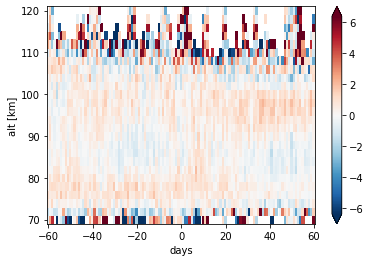

In [54]:
sea_gw_u_cma.plot(x='days',robust=True)

##### Anomalies of the u-component of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


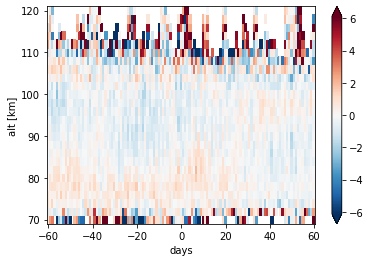

In [55]:
sea_gw_u_cma_anomalie.plot(x='days',robust=True)

##### v-component of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


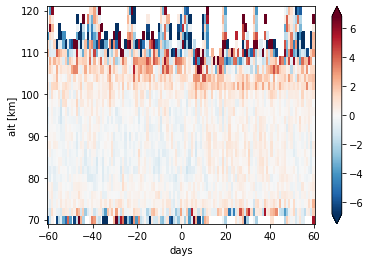

In [56]:
sea_gw_v_cma.plot(x='days',robust=True)

##### Anomalies of the v-component of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


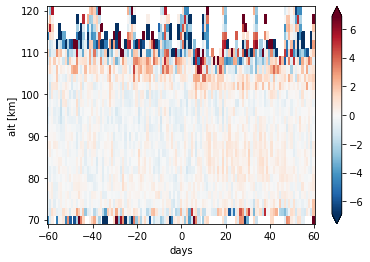

In [57]:
sea_gw_v_cma_anomalie.plot(x='days',robust=True)

##### Total kinetic energy of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


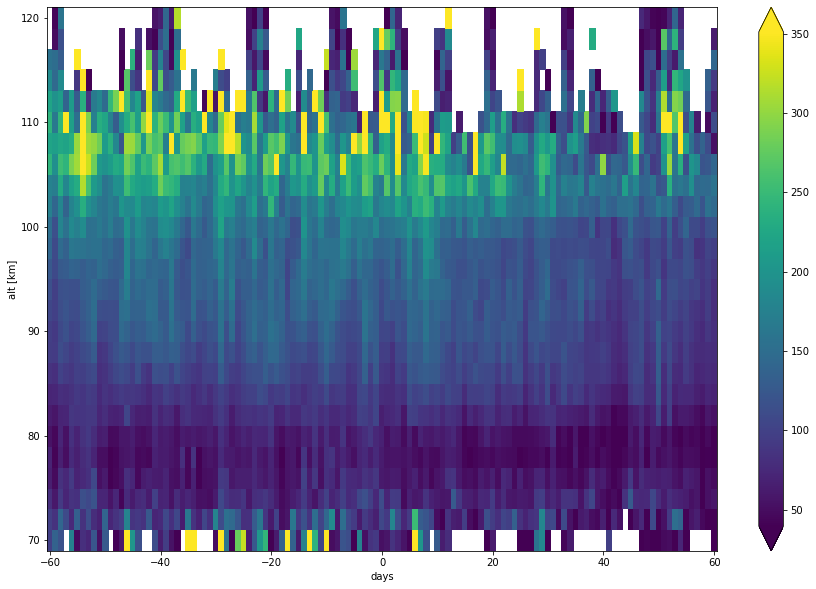

In [58]:
sea_gw_total_energy_cma.plot(x='days',size=10,robust=True)

##### Anomalies of the total kinetic energy of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


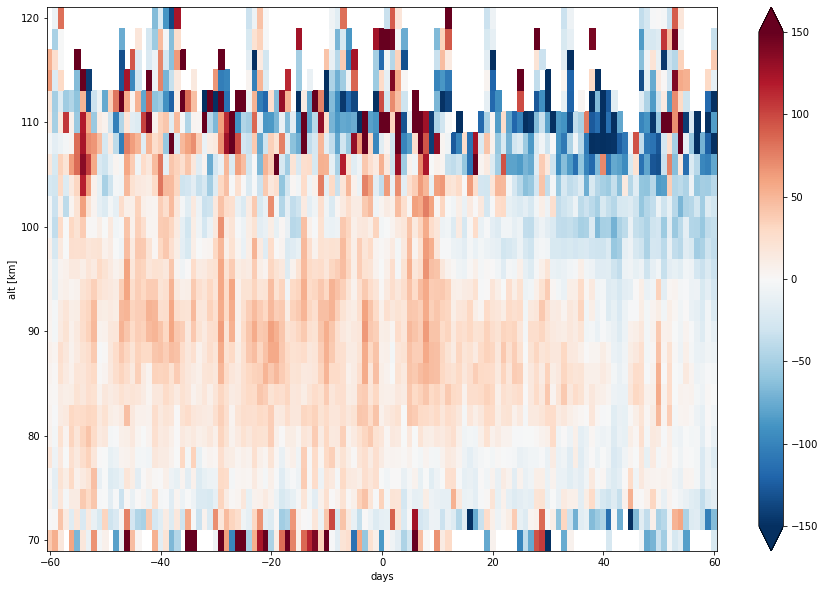

In [59]:
sea_gw_total_energy_cma_anomalie.plot(x='days',size=10,vmax=150,robust=True)

#### Davis (Antarctic)

In [60]:
gw_total_energy_dav = kin_energy_grav_waves('Dav')

sea_gw_total_energy_dav = sea(60,'Dav',gw_total_energy_dav)


gw_total_energy_dav_anomalie = anomalie('day',gw_total_energy_dav)

sea_gw_total_energy_dav_anomalie = sea(60,'Rio',gw_total_energy_dav_anomalie)


gw_u_dav = grav_waves('u','Dav')
gw_v_dav = grav_waves('v','Dav')

sea_gw_u_dav = sea(60,'Dav',gw_u_dav)
sea_gw_v_dav = sea(60,'Dav',gw_v_dav)

gw_u_dav_anomalie = anomalie('day',gw_u_dav)
gw_v_dav_anomalie = anomalie('day',gw_v_dav)

sea_gw_u_dav_anomalie = sea(60,'Dav',gw_u_dav_anomalie)
sea_gw_v_dav_anomalie = sea(60,'Dav',gw_v_dav_anomalie)

##### u-component of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


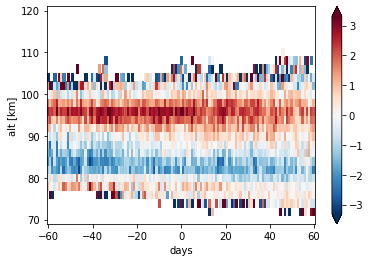

In [61]:
sea_gw_u_dav.plot(x='days',robust=True)

##### Anomalies of the u-component of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


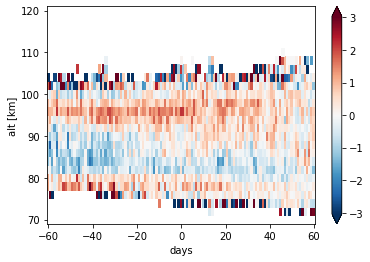

In [62]:
sea_gw_u_dav_anomalie.plot(x='days',robust=True)

##### v-component of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


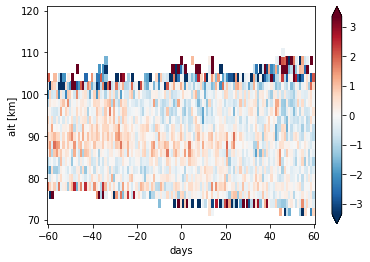

In [63]:
sea_gw_v_dav.plot(x='days',robust=True)

##### Anomalies of the v-component of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


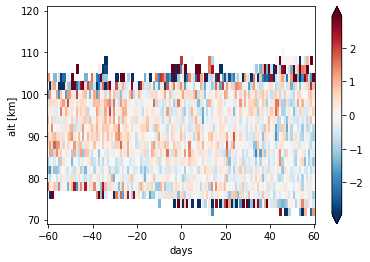

In [64]:
sea_gw_v_dav_anomalie.plot(x='days',robust=True)

##### Total kinetic energy of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


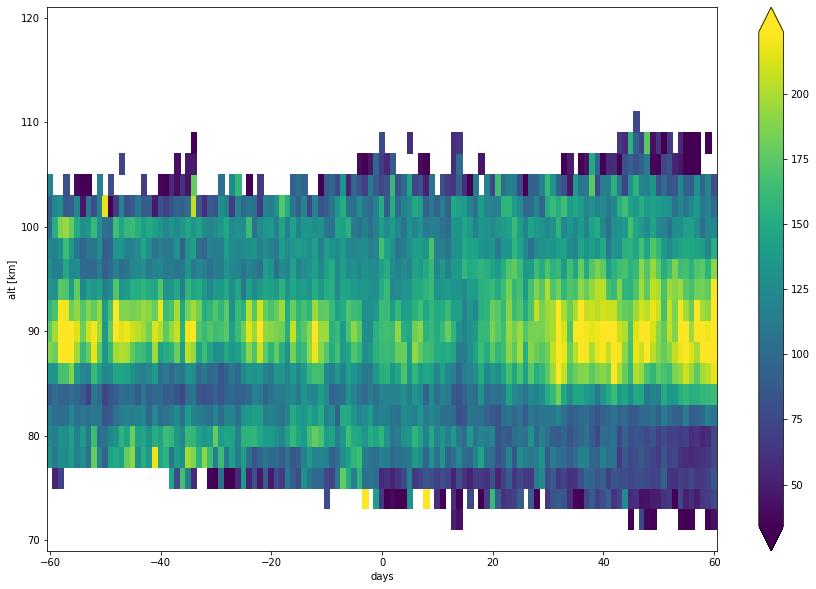

In [65]:
sea_gw_total_energy_dav.plot(x='days',size=10,robust=True)

##### Anomalies of the total kinetic energy of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


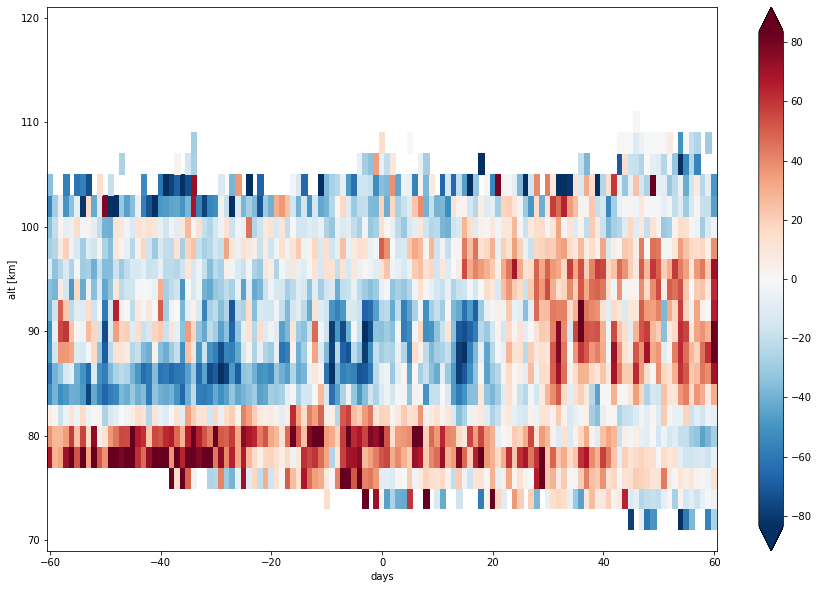

In [66]:
sea_gw_total_energy_dav_anomalie.plot(x='days',size=10,robust=True)

#### Kiruna, Norrbotten (Sweden)

In [67]:
gw_total_energy_kir = kin_energy_grav_waves('Kir')

sea_gw_total_energy_kir = sea(60,'Kir',gw_total_energy_kir)


gw_total_energy_kir_anomalie = anomalie('day',gw_total_energy_kir)

sea_gw_total_energy_kir_anomalie = sea(60,'Kir',gw_total_energy_kir_anomalie)


gw_u_kir = grav_waves('u','Kir')
gw_v_kir = grav_waves('v','Kir')

sea_gw_u_kir = sea(60,'Kir',gw_u_kir)
sea_gw_v_kir = sea(60,'Kir',gw_v_kir)

gw_u_kir_anomalie = anomalie('day',gw_u_kir)
gw_v_kir_anomalie = anomalie('day',gw_v_kir)

sea_gw_u_kir_anomalie = sea(60,'Kir',gw_u_kir_anomalie)
sea_gw_v_kir_anomalie = sea(60,'Kir',gw_v_kir_anomalie)

##### u-component of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


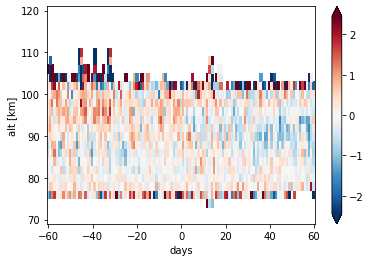

In [68]:
sea_gw_u_kir.plot(x='days',robust=True)

##### Anomalies of the u-component of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


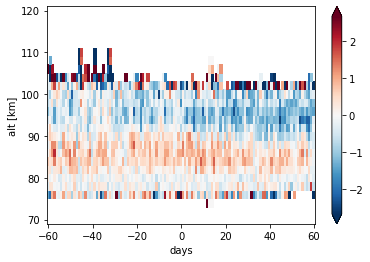

In [69]:
sea_gw_u_kir_anomalie.plot(x='days',robust=True)

##### v-component of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


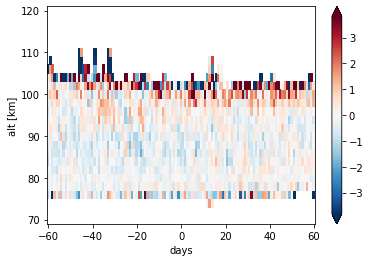

In [70]:
sea_gw_v_kir.plot(x='days',robust=True)

##### Anomalies of the v-component of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


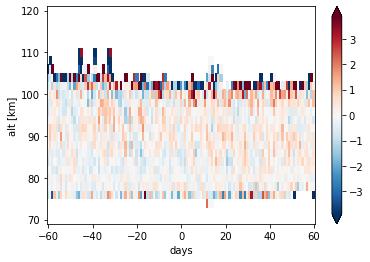

In [71]:
sea_gw_v_kir_anomalie.plot(x='days',robust=True)

##### Total kinetic energy of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


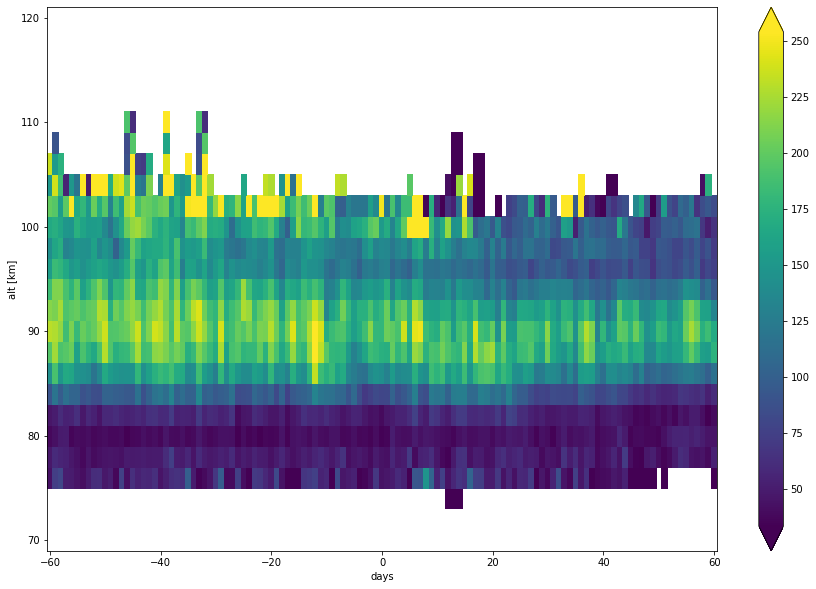

In [72]:
sea_gw_total_energy_kir.plot(x='days',size=10,robust=True)

##### Anomalies of the total kinetic energy of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


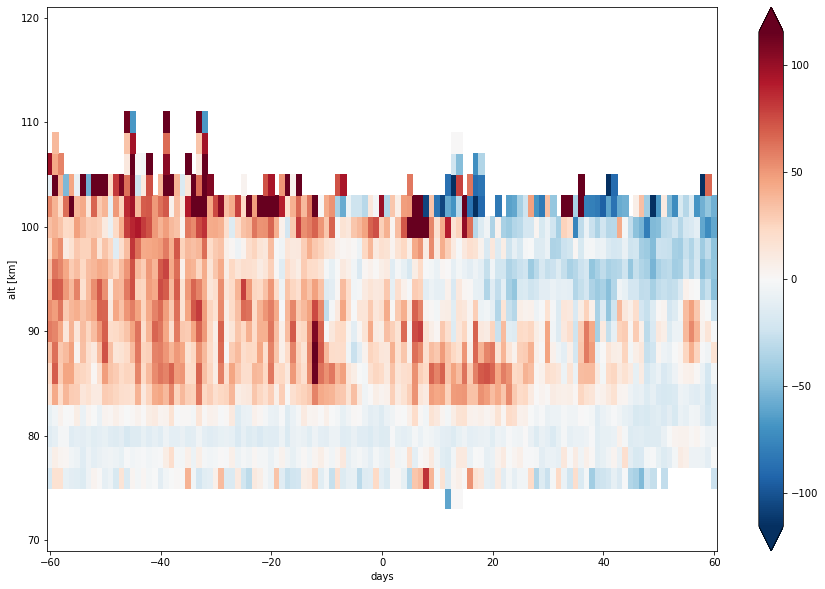

In [73]:
sea_gw_total_energy_kir_anomalie.plot(x='days',size=10,robust=True)

#### Interpretation

Concerning the gravity waves we see a different behaviour for both hemispheres. The meteor radars on the northern hemisphere (Collm, Kiruna, CMA) show an increased level of gravity wave kinetic energy before and around - maybe short time after, too - the onset of the SSW's. Later the activity of gravity waves reduces to the normal climatological amount.

On the southern hemisphere (RioGrande, Davis) this is vice-versa. Before the SSW-onset gravity waves are at a low level. Approximately 2 to 3 weeks afterwards the kinetic energy is significantly increased compared to the climatological mean.

--> Reason?
The reason for the enhanced level of gravity wave kinetic energy on the northern hemisphere before the SSW onset could be the jetstream which intensifies typically before the beginning of a SSW event. Because of the increased wind speed the gravity wave filtering is changed in that way, that more waves with larger wave numbers can propagate further upward which leads to the observed enhanced gravity wave activity in higher altitudes (here: 85-95 km).

--> Validate this jet intensification with GAIA model data!!! There the increased wind speed should be seen in the altitudes below (around 50 km where the jetstream usually is).


The structures on the Southern Hemisphere are caused by the so-calles "inter-hemispheric coupling". Maybe look for that in literature or simply say it was not investigated in this project.

### Tides --> do not investigate --> would be too much!

#### Collm

In [74]:
tides_col = read_group('tides','Col')

diurnal_u_col = read_var(tides_col,'A24u')
semidiurnal_u_col = read_var(tides_col,'A12u')
terdiurnal_u_col = read_var(tides_col,'A8u')

In [75]:
sea_diurnal_u_col = sea(30,'Col',diurnal_u_col)
sea_semidiurnal_u_col = sea(30,'Col',semidiurnal_u_col)
sea_terdiurnal_u_col = sea(30,'Col',terdiurnal_u_col)

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


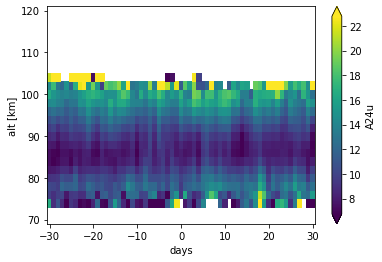

In [76]:
sea_diurnal_u_col.plot(x='days',robust=True)

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


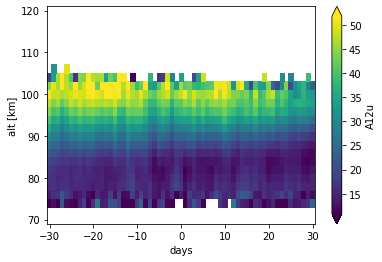

In [77]:
sea_semidiurnal_u_col.plot(x='days',robust=True)

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


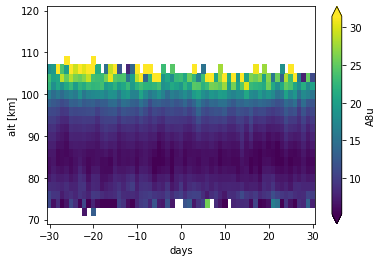

In [78]:
sea_terdiurnal_u_col.plot(x='days',robust=True)

## GAIA data

### General definitions

In [79]:
root_path = '/home/gemeinsam_tmp/UA_students/data/'
fname = ''

In [80]:
def read_gaia_group(gruppe,loc):
   
    if loc=='Rio':
        timestart = '2008-02-01'
        timeend = '2019-12-31'
        fname = 'GAIA_Rio_20080201_20141231_run20200603.nc'
    
    elif loc == 'Col':
        timestart =  '2004-08-01'
        timeend =  '2017-12-31'
        fname= 'GAIA_Col_20040801_20171231_run20200604.nc'
    
    elif loc=='CMA':
        timestart = '2002-01-01'
        timeend = '2018-12-31'
        fname = 'GAIA_CMA_20020101_20171231_run20200531.nc'
    elif loc=='Kir':
        timestart = '1999-08-01'
        timeend = '2017-12-31'
        fname = 'GAIA_Kir_19990801_20171231_run20200605.nc'    
    elif loc=='Dav':
        timestart = '2005-01-01'
        timeend = '2017-12-31'
        fname = 'GAIA_Dav_20050101_20171231_run20200604.nc'  
    
    infile = f'{root_path}{fname}'
    ds = xr.open_dataset(infile, group=gruppe)
    ds['time'] = pd.date_range(start = timestart, end = timeend, periods=ds.time.shape[0])
    ds = ds.chunk({'alt': 12})
    return ds

### Wind model data analysis

#### Collm

In [81]:
ds_col_gaia = read_gaia_group('GAIA','Col')
print(ds_col_gaia)

u_col_gaia = read_var(ds_col_gaia,'u')
v_col_gaia = read_var(ds_col_gaia,'v')

u_col_gaia_anomalie = anomalie('hour',u_col_gaia)
# u_col_anomalie.plot(x='time',robust=True)

v_col_gaia_anomalie = anomalie('day',v_col_gaia)

sea_u_col_gaia = sea(30,'Col',u_col_gaia)
sea_u_col_gaia_anomalie = sea(30,'Col',u_col_gaia_anomalie)

sea_v_col_gaia = sea(30,'Col',v_col_gaia)
sea_v_col_gaia_anomalie = sea(30,'Col',v_col_gaia_anomalie)

<xarray.Dataset>
Dimensions:    (alt: 93, time: 117624)
Coordinates:
  * alt        (alt) float64 16.0 18.0 20.0 22.0 ... 340.0 360.0 380.0 400.0
  * time       (time) datetime64[ns] 2004-08-01 ... 2017-12-31
Data variables:
    u          (time, alt) float64 dask.array<chunksize=(117624, 12), meta=np.ndarray>
    v          (time, alt) float64 dask.array<chunksize=(117624, 12), meta=np.ndarray>
    w          (time, alt) float64 dask.array<chunksize=(117624, 12), meta=np.ndarray>
    u_err      (time, alt) float64 dask.array<chunksize=(117624, 12), meta=np.ndarray>
    v_err      (time, alt) float64 dask.array<chunksize=(117624, 12), meta=np.ndarray>
    w_err      (time, alt) float64 dask.array<chunksize=(117624, 12), meta=np.ndarray>
    temp       (time, alt) float64 dask.array<chunksize=(117624, 12), meta=np.ndarray>
    temp_err   (time, alt) float64 dask.array<chunksize=(117624, 12), meta=np.ndarray>
    u_fil      (time, alt) float64 dask.array<chunksize=(117624, 12), meta=np.n

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 4901 times more chunks
  return self.array[key]
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 159 times more chunks
  return self.array[key]


##### Climatology of u-component

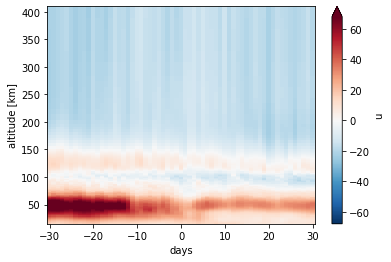

In [82]:
sea_u_col_gaia.plot(x='days',robust=True)

##### Anomalies of u-component

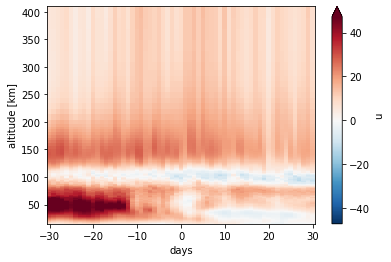

In [83]:
sea_u_col_gaia_anomalie.plot(x='days',robust=True)

##### Climatology of v-component

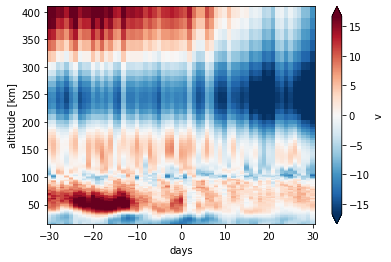

In [84]:
sea_v_col_gaia.plot(x='days',robust=True)

##### Anomalies of v-component

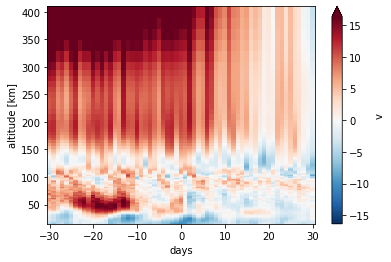

In [85]:
sea_v_col_gaia_anomalie.plot(x='days',robust=True)

#### Rio

In [86]:
ds_rio_gaia = read_gaia_group('GAIA','Rio')
#print(ds_rio_gaia)

u_rio_gaia = read_var(ds_rio_gaia,'u')
v_rio_gaia = read_var(ds_rio_gaia,'v')

u_rio_gaia_anomalie = anomalie('day',u_rio_gaia)

v_rio_gaia_anomalie = anomalie('day',v_rio_gaia)

sea_u_rio_gaia = sea(30,'Rio',u_rio_gaia)
sea_u_rio_gaia_anomalie = sea(30,'Rio',u_rio_gaia_anomalie)

sea_v_rio_gaia = sea(30,'Rio',v_rio_gaia)
sea_v_rio_gaia_anomalie = sea(30,'Rio',v_rio_gaia_anomalie)

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 141 times more chunks
  return self.array[key]
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 141 times more chunks
  return self.array[key]


##### Climatology of u-component

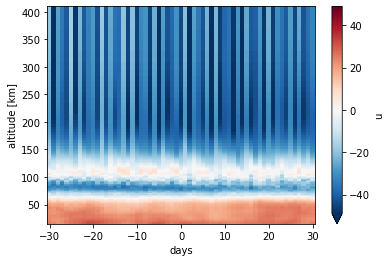

In [87]:
sea_u_rio_gaia.plot(x='days',robust=True)

##### Anomalies of u-component

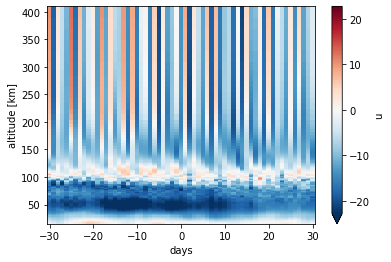

In [88]:
sea_u_rio_gaia_anomalie.plot(x='days',robust=True)

##### Climatology of v-component

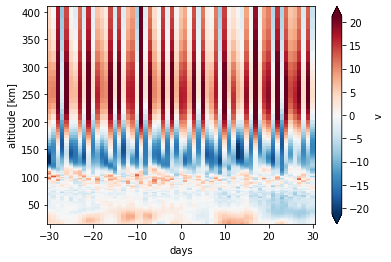

In [89]:
sea_v_rio_gaia.plot(x='days',robust=True)

##### Anomalies of v-component

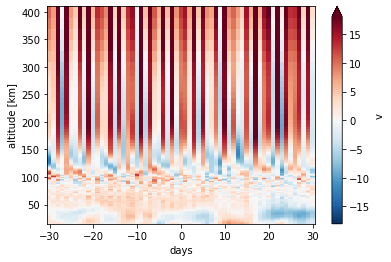

In [90]:
sea_v_rio_gaia_anomalie.plot(x='days',robust=True)

#### CMA Canadian Meteor Orbit Radar (CMOR) (London, Ontario - Canada)

In [91]:
ds_cma_gaia = read_gaia_group('GAIA','CMA')
#print(ds_cma_gaia)

u_cma_gaia = read_var(ds_cma_gaia,'u')
v_cma_gaia = read_var(ds_cma_gaia,'v')

u_cma_gaia_anomalie = anomalie('day',u_cma_gaia)

v_cma_gaia_anomalie = anomalie('day',v_cma_gaia)

sea_u_cma_gaia = sea(30,'CMA',u_cma_gaia)
sea_u_cma_gaia_anomalie = sea(30,'CMA',u_cma_gaia_anomalie)

sea_v_cma_gaia = sea(30,'CMA',v_cma_gaia)
sea_v_cma_gaia_anomalie = sea(30,'CMA',v_cma_gaia_anomalie)

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 201 times more chunks
  return self.array[key]
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 201 times more chunks
  return self.array[key]


##### Climatology of u-component

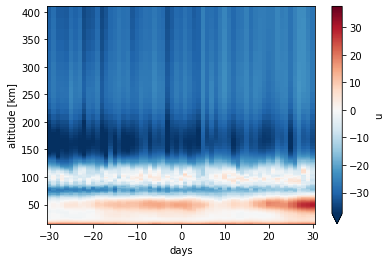

In [92]:
sea_u_cma_gaia.plot(x='days',robust=True)

##### Anomalies of u-component

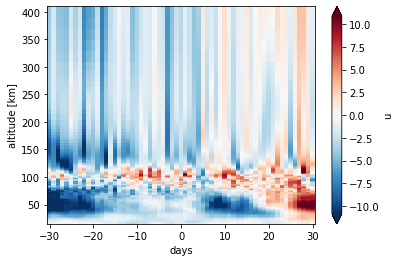

In [93]:
sea_u_cma_gaia_anomalie.plot(x='days',robust=True)

##### Climatology of v-component

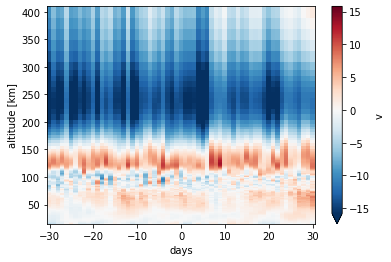

In [94]:
sea_v_cma_gaia.plot(x='days',robust=True)

##### Anomalies of v-component

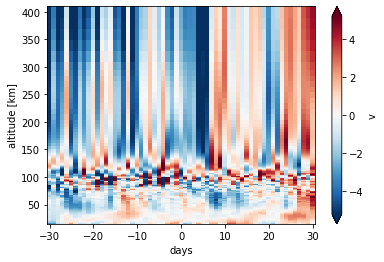

In [95]:
sea_v_cma_gaia_anomalie.plot(x='days',robust=True)

#### Davis (Antarctic)

In [96]:
ds_dav_gaia = read_gaia_group('GAIA','Dav')
#print(ds_dav_gaia)

u_dav_gaia = read_var(ds_dav_gaia,'u')
v_dav_gaia = read_var(ds_dav_gaia,'v')

u_dav_gaia_anomalie = anomalie('day',u_dav_gaia)

v_dav_gaia_anomalie = anomalie('day',v_dav_gaia)

sea_u_dav_gaia = sea(30,'Dav',u_dav_gaia)
sea_u_dav_gaia_anomalie = sea(30,'Dav',u_dav_gaia_anomalie)

sea_v_dav_gaia = sea(30,'Dav',v_dav_gaia)
sea_v_dav_gaia_anomalie = sea(30,'Dav',v_dav_gaia_anomalie)

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 154 times more chunks
  return self.array[key]
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 154 times more chunks
  return self.array[key]


##### Climatology of u-component

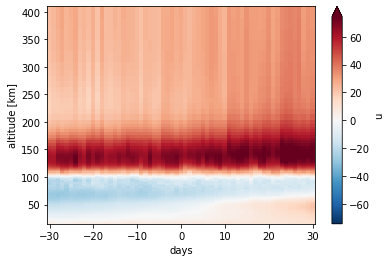

In [97]:
sea_u_dav_gaia.plot(x='days',robust=True)

##### Anomalies of u-component

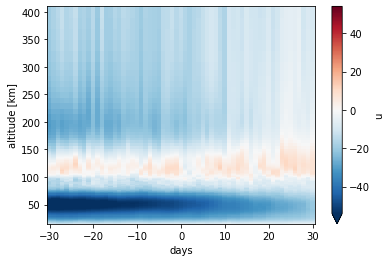

In [98]:
sea_u_dav_gaia_anomalie.plot(x='days',robust=True)

##### Climatology of v-component

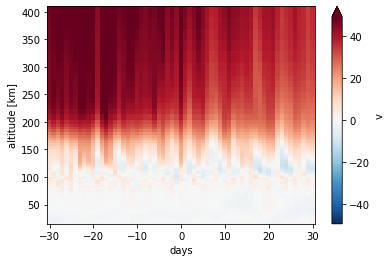

In [99]:
sea_v_dav_gaia.plot(x='days',robust=True)

##### Anomalies of v-component

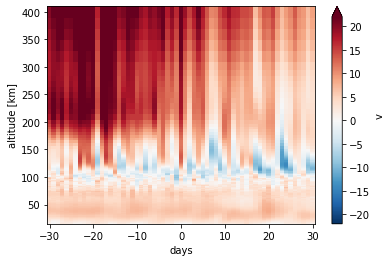

In [100]:
sea_v_dav_gaia_anomalie.plot(x='days',robust=True)

#### Kiruna, Norrbotten (Sweden)

In [101]:
ds_kir_gaia = read_gaia_group('GAIA','Kir')
#print(ds_kir_gaia)

u_kir_gaia = read_var(ds_kir_gaia,'u')
v_kir_gaia = read_var(ds_kir_gaia,'v')

u_kir_gaia_anomalie = anomalie('day',u_kir_gaia)

v_kir_gaia_anomalie = anomalie('day',v_kir_gaia)

sea_u_kir_gaia = sea(30,'Kir',u_kir_gaia)
sea_u_kir_gaia_anomalie = sea(30,'Kir',u_kir_gaia_anomalie)

sea_v_kir_gaia = sea(30,'Kir',v_kir_gaia)
sea_v_kir_gaia_anomalie = sea(30,'Kir',v_kir_gaia_anomalie)

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 218 times more chunks
  return self.array[key]
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 218 times more chunks
  return self.array[key]


##### Climatology of u-component

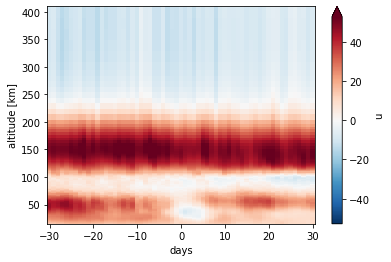

In [102]:
sea_u_kir_gaia.plot(x='days',robust=True)

##### Anomalies of u-component

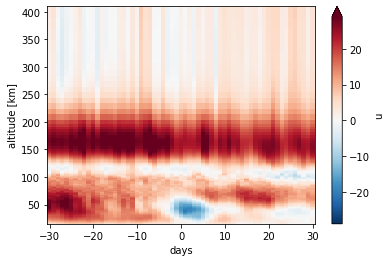

In [103]:
sea_u_kir_gaia_anomalie.plot(x='days',robust=True)

##### Climatology of v-component

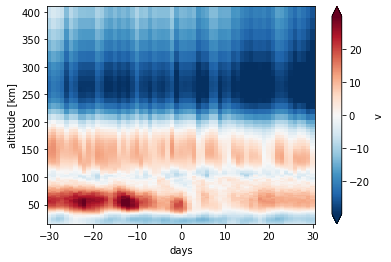

In [104]:
sea_v_kir_gaia.plot(x='days',robust=True)

##### Anomalies of v-component

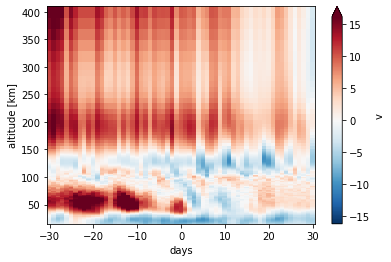

In [105]:
sea_v_kir_gaia_anomalie.plot(x='days',robust=True)

### Gravity waves model data analysis

#### Collm

In [106]:
gw_u_col_gaia = grav_waves_gaia('u',ds_col_gaia)
gw_v_col_gaia = grav_waves_gaia('v',ds_col_gaia)
gw_total_energy_col_gaia = kin_energy_grav_waves_gaia(ds_col_gaia)

sea_gw_u_col_gaia = sea(60,'Col',gw_u_col_gaia)
sea_gw_v_col_gaia = sea(60,'Col',gw_v_col_gaia)
sea_gw_total_energy_col_gaia = sea(60,'Col',gw_total_energy_col_gaia)


gw_total_energy_col_gaia_anomalie = anomalie('day',gw_total_energy_col_gaia)
gw_u_col_gaia_anomalie = anomalie('day',gw_u_col_gaia)
gw_v_col_gaia_anomalie = anomalie('day',gw_v_col_gaia)

sea_gw_total_energy_col_gaia_anomalie = sea(60,'Col',gw_total_energy_col_gaia_anomalie)
sea_gw_u_col_gaia_anomalie = sea(60,'Col',gw_u_col_gaia_anomalie)
sea_gw_v_col_gaia_anomalie = sea(60,'Col',gw_v_col_gaia_anomalie)

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 159 times more chunks
  return self.array[key]
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 159 times more chunks
  return self.array[key]
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 159 times more chunks
  return self.array[key]


##### u-component of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


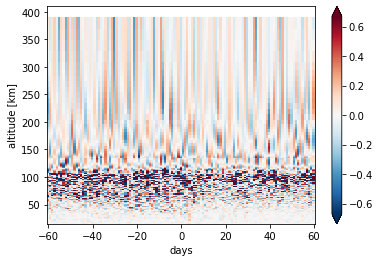

In [107]:
sea_gw_u_col_gaia.plot(x='days',robust=True)

##### Anomalies of the u-component of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


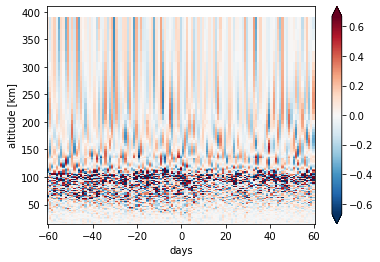

In [108]:
sea_gw_u_col_gaia_anomalie.plot(x='days',robust=True)

##### v-component of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


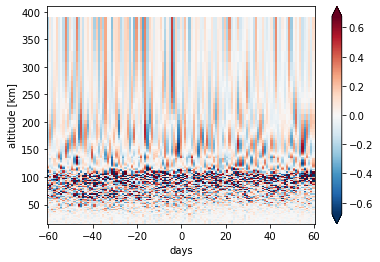

In [109]:
sea_gw_v_col_gaia.plot(x='days',robust=True)

##### Anomalies of the v-component of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


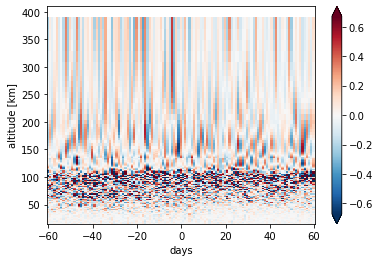

In [110]:
sea_gw_v_col_gaia_anomalie.plot(x='days',robust=True)

##### Total kinetic energy of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


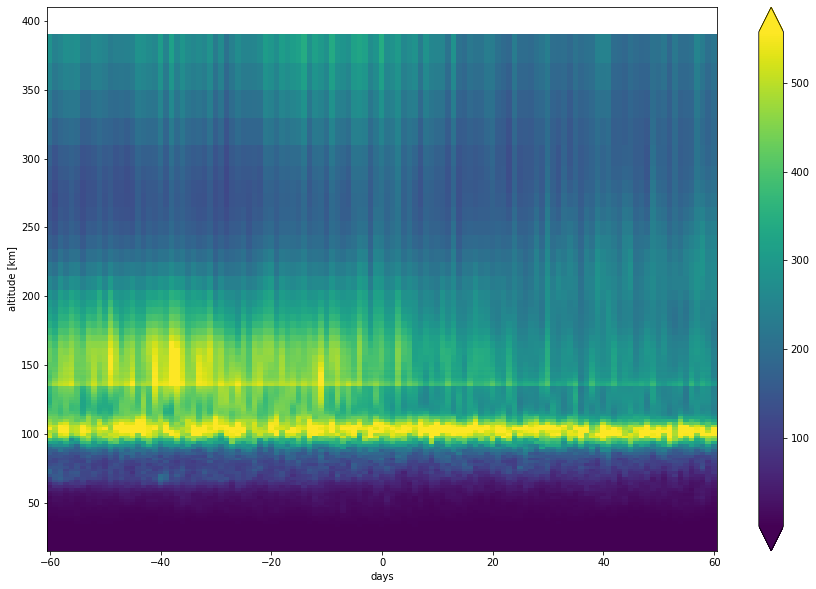

In [111]:
sea_gw_total_energy_col_gaia.plot(x='days',size=10,robust=True)

##### Anomalies of the total kinetic energy of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


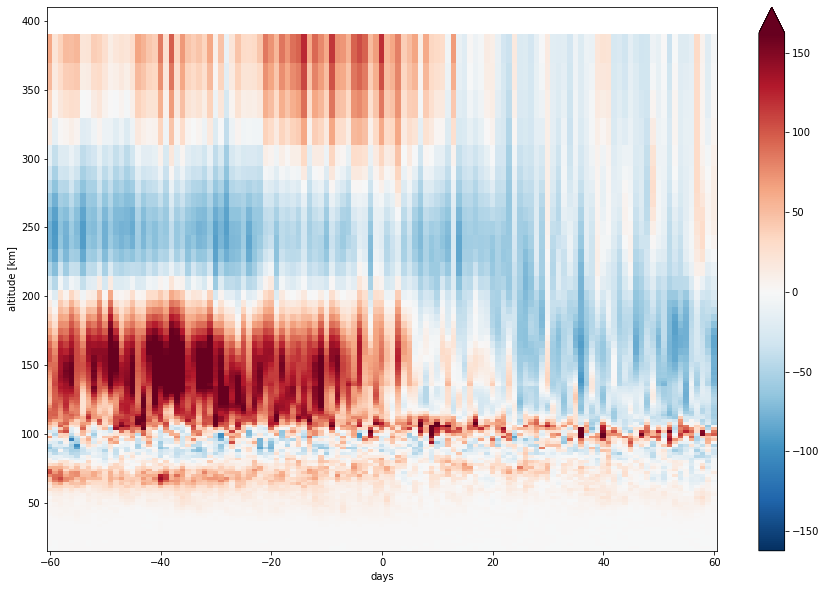

In [112]:
sea_gw_total_energy_col_gaia_anomalie.plot(x='days',size=10,robust=True)

#### Rio

In [113]:
gw_u_rio_gaia = grav_waves_gaia('u',ds_rio_gaia)
gw_v_rio_gaia = grav_waves_gaia('v',ds_rio_gaia)
gw_total_energy_rio_gaia = kin_energy_grav_waves_gaia(ds_rio_gaia)

sea_gw_u_rio_gaia = sea(60,'Rio',gw_u_rio_gaia)
sea_gw_v_rio_gaia = sea(60,'Rio',gw_v_rio_gaia)
sea_gw_total_energy_rio_gaia = sea(60,'Rio',gw_total_energy_rio_gaia)


gw_total_energy_rio_gaia_anomalie = anomalie('day',gw_total_energy_rio_gaia)
gw_u_rio_gaia_anomalie = anomalie('day',gw_u_rio_gaia)
gw_v_rio_gaia_anomalie = anomalie('day',gw_v_rio_gaia)

sea_gw_total_energy_rio_gaia_anomalie = sea(60,'Rio',gw_total_energy_rio_gaia_anomalie)
sea_gw_u_rio_gaia_anomalie = sea(60,'Rio',gw_u_rio_gaia_anomalie)
sea_gw_v_rio_gaia_anomalie = sea(60,'Rio',gw_v_rio_gaia_anomalie)

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 141 times more chunks
  return self.array[key]
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 141 times more chunks
  return self.array[key]
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 141 times more chunks
  return self.array[key]


##### u-component of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


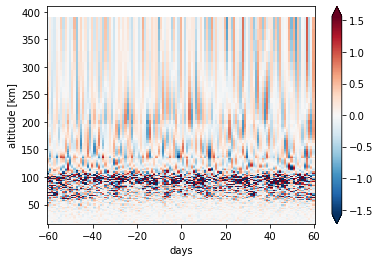

In [114]:
sea_gw_u_rio_gaia.plot(x='days',robust=True)

##### Anomalies of the u-component of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


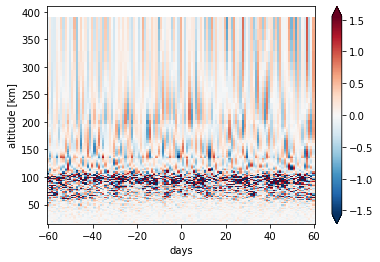

In [115]:
sea_gw_u_rio_gaia_anomalie.plot(x='days',robust=True)

##### v-component of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


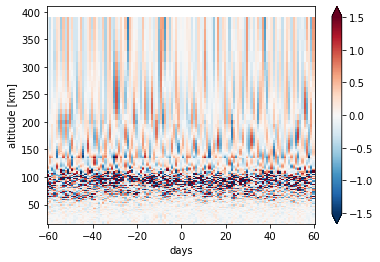

In [116]:
sea_gw_v_rio_gaia.plot(x='days',robust=True)

##### Anomalies of the v-component of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


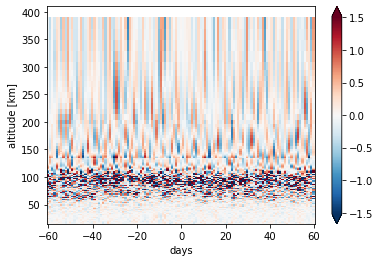

In [117]:
sea_gw_v_rio_gaia_anomalie.plot(x='days',robust=True)

##### Total kinetic energy of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


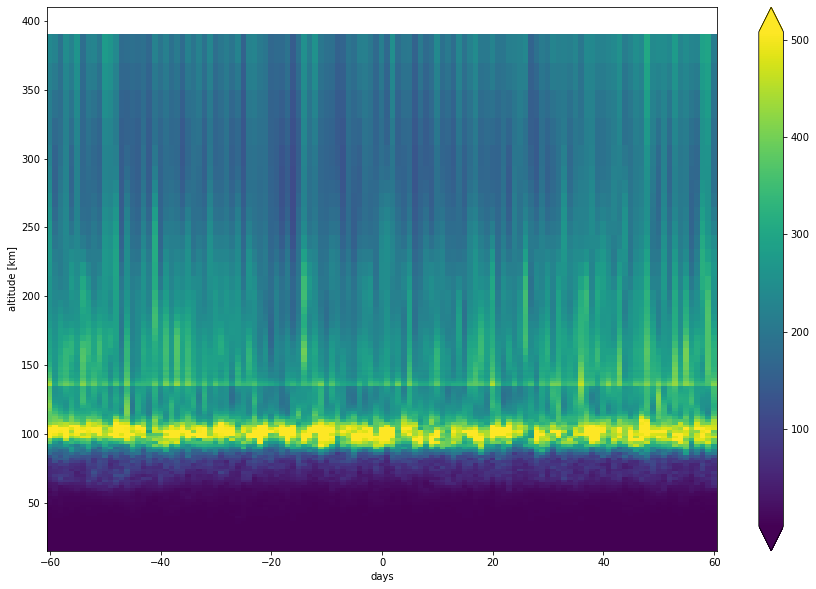

In [118]:
sea_gw_total_energy_rio_gaia.plot(x='days',size=10,robust=True)

##### Anomalies of the total kinetic energy of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


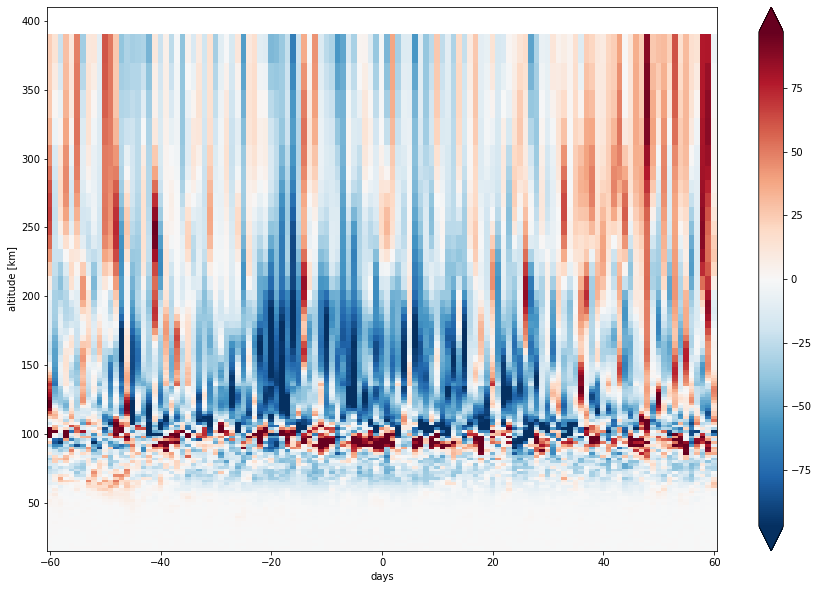

In [119]:
sea_gw_total_energy_rio_gaia_anomalie.plot(x='days',size=10,robust=True)

#### CMA

In [120]:
gw_u_cma_gaia = grav_waves_gaia('u',ds_cma_gaia)
gw_v_cma_gaia = grav_waves_gaia('v',ds_cma_gaia)
gw_total_energy_cma_gaia = kin_energy_grav_waves_gaia(ds_cma_gaia)

sea_gw_u_cma_gaia = sea(60,'CMA',gw_u_cma_gaia)
sea_gw_v_cma_gaia = sea(60,'CMA',gw_v_cma_gaia)
sea_gw_total_energy_cma_gaia = sea(60,'CMA',gw_total_energy_cma_gaia)


gw_total_energy_cma_gaia_anomalie = anomalie('day',gw_total_energy_cma_gaia)
gw_u_cma_gaia_anomalie = anomalie('day',gw_u_cma_gaia)
gw_v_cma_gaia_anomalie = anomalie('day',gw_v_cma_gaia)

sea_gw_total_energy_cma_gaia_anomalie = sea(60,'CMA',gw_total_energy_cma_gaia_anomalie)
sea_gw_u_cma_gaia_anomalie = sea(60,'CMA',gw_u_cma_gaia_anomalie)
sea_gw_v_cma_gaia_anomalie = sea(60,'CMA',gw_v_cma_gaia_anomalie)

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 201 times more chunks
  return self.array[key]
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 201 times more chunks
  return self.array[key]
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 201 times more chunks
  return self.array[key]


##### u-component of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


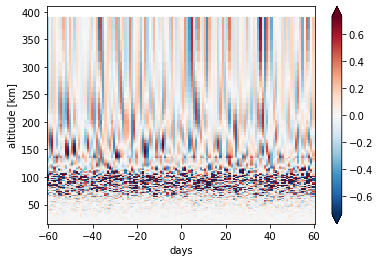

In [121]:
sea_gw_u_cma_gaia.plot(x='days',robust=True)

##### Anomalies of the u-component of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


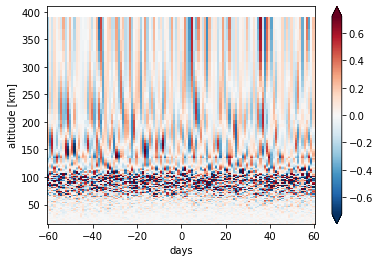

In [122]:
sea_gw_u_cma_gaia_anomalie.plot(x='days',robust=True)

##### v-component of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


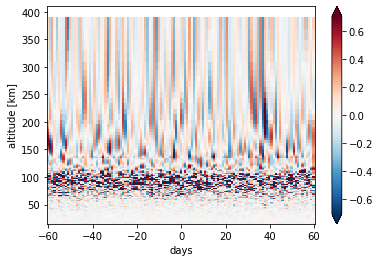

In [123]:
sea_gw_v_cma_gaia.plot(x='days',robust=True)

##### Anomalies of the v-component of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


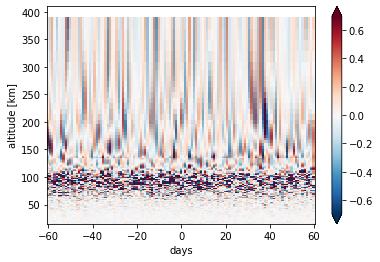

In [124]:
sea_gw_v_cma_gaia_anomalie.plot(x='days',robust=True)

##### Total kinetic energy of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


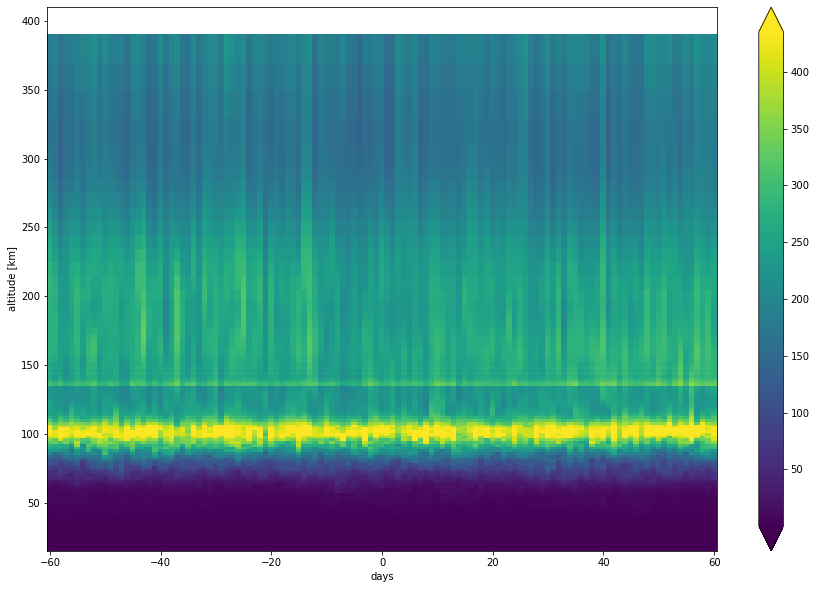

In [125]:
sea_gw_total_energy_cma_gaia.plot(x='days',size=10,robust=True)

##### Anomalies of the total kinetic energy of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


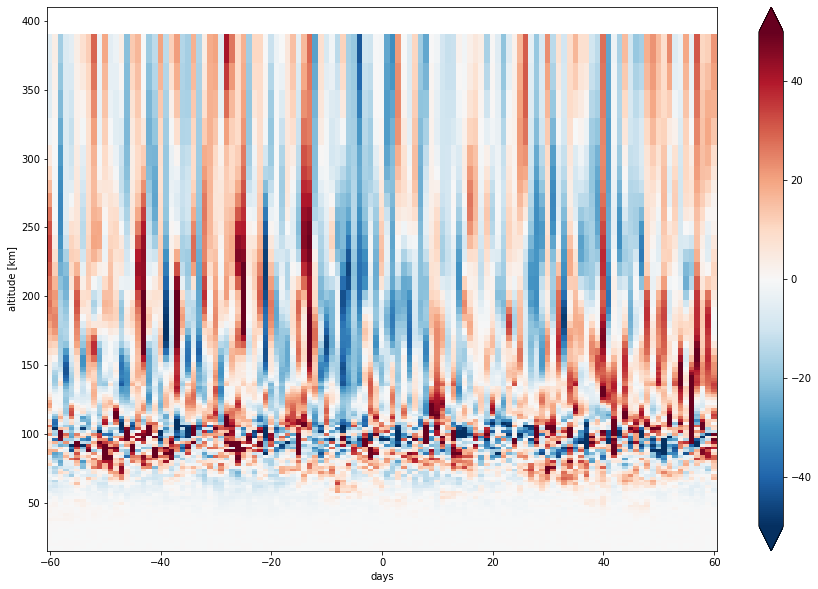

In [126]:
sea_gw_total_energy_cma_gaia_anomalie.plot(x='days',size=10,robust=True)

#### Davis (Antarctic)

In [127]:
gw_u_dav_gaia = grav_waves_gaia('u',ds_dav_gaia)
gw_v_dav_gaia = grav_waves_gaia('v',ds_dav_gaia)
gw_total_energy_dav_gaia = kin_energy_grav_waves_gaia(ds_dav_gaia)

sea_gw_u_dav_gaia = sea(60,'Dav',gw_u_dav_gaia)
sea_gw_v_dav_gaia = sea(60,'Dav',gw_v_dav_gaia)
sea_gw_total_energy_dav_gaia = sea(60,'Dav',gw_total_energy_dav_gaia)


gw_total_energy_dav_gaia_anomalie = anomalie('day',gw_total_energy_dav_gaia)
gw_u_dav_gaia_anomalie = anomalie('day',gw_u_dav_gaia)
gw_v_dav_gaia_anomalie = anomalie('day',gw_v_dav_gaia)

sea_gw_total_energy_dav_gaia_anomalie = sea(60,'Dav',gw_total_energy_dav_gaia_anomalie)
sea_gw_u_dav_gaia_anomalie = sea(60,'Dav',gw_u_dav_gaia_anomalie)
sea_gw_v_dav_gaia_anomalie = sea(60,'Dav',gw_v_dav_gaia_anomalie)

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 154 times more chunks
  return self.array[key]
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 154 times more chunks
  return self.array[key]
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 154 times more chunks
  return self.array[key]


##### u-component of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


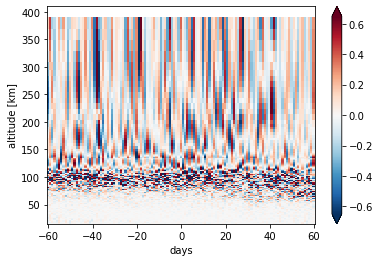

In [128]:
sea_gw_u_dav_gaia.plot(x='days',robust=True)

##### Anomalies of the u-component of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


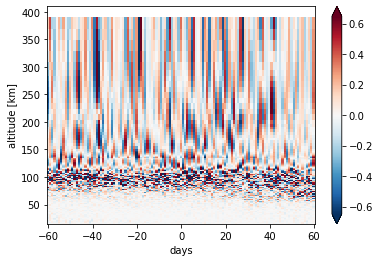

In [129]:
sea_gw_u_dav_gaia_anomalie.plot(x='days',robust=True)

##### v-component of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


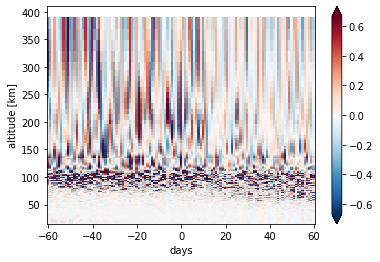

In [130]:
sea_gw_v_dav_gaia.plot(x='days',robust=True)

##### Anomalies of the v-component of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


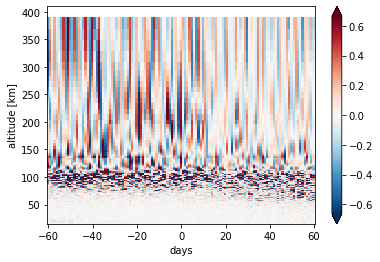

In [131]:
sea_gw_v_dav_gaia_anomalie.plot(x='days',robust=True)

##### Total kinetic energy of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


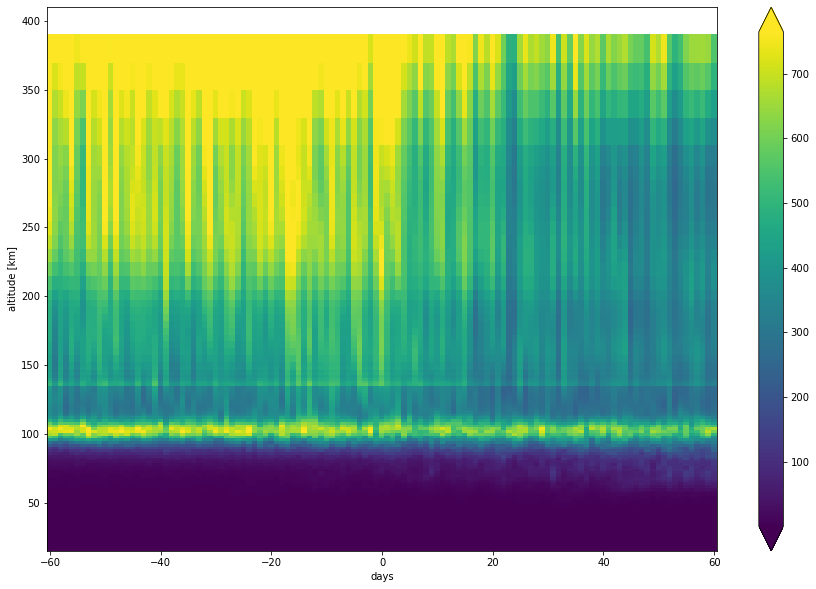

In [132]:
sea_gw_total_energy_dav_gaia.plot(x='days',size=10,robust=True)

##### Anomalies of the total kinetic energy of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


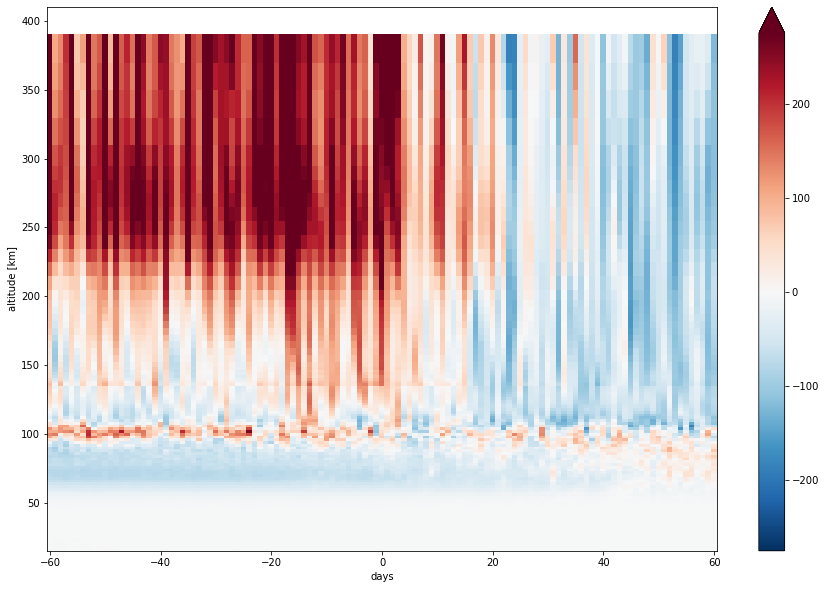

In [133]:
sea_gw_total_energy_dav_gaia_anomalie.plot(x='days',size=10,robust=True)

#### Kiruna, Norrbotten (Sweden)

In [134]:
gw_u_kir_gaia = grav_waves_gaia('u',ds_kir_gaia)
gw_v_kir_gaia = grav_waves_gaia('v',ds_kir_gaia)
gw_total_energy_kir_gaia = kin_energy_grav_waves_gaia(ds_kir_gaia)

sea_gw_u_kir_gaia = sea(60,'Kir',gw_u_kir_gaia)
sea_gw_v_kir_gaia = sea(60,'Kir',gw_v_kir_gaia)
sea_gw_total_energy_kir_gaia = sea(60,'Kir',gw_total_energy_kir_gaia)


gw_total_energy_kir_gaia_anomalie = anomalie('day',gw_total_energy_kir_gaia)
gw_u_kir_gaia_anomalie = anomalie('day',gw_u_kir_gaia)
gw_v_kir_gaia_anomalie = anomalie('day',gw_v_kir_gaia)

sea_gw_total_energy_kir_gaia_anomalie = sea(60,'Kir',gw_total_energy_kir_gaia_anomalie)
sea_gw_u_kir_gaia_anomalie = sea(60,'Kir',gw_u_kir_gaia_anomalie)
sea_gw_v_kir_gaia_anomalie = sea(60,'Kir',gw_v_kir_gaia_anomalie)

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 218 times more chunks
  return self.array[key]
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 218 times more chunks
  return self.array[key]
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 218 times more chunks
  return self.array[key]


##### u-component of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


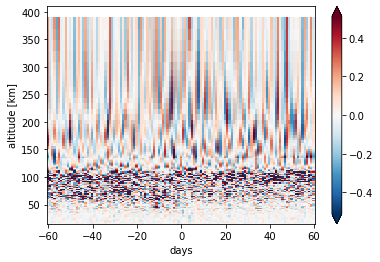

In [135]:
sea_gw_u_kir_gaia.plot(x='days',robust=True)

##### Anomalies of the u-component of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


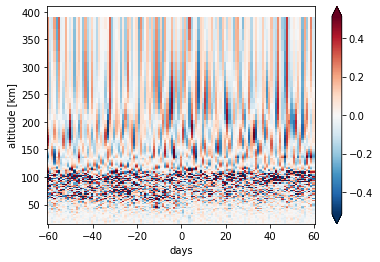

In [136]:
sea_gw_u_kir_gaia_anomalie.plot(x='days',robust=True)

##### v-component of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


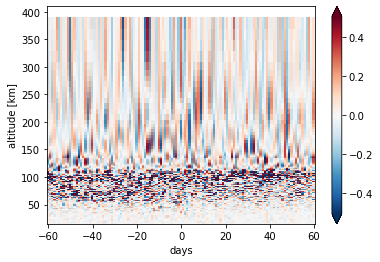

In [137]:
sea_gw_v_kir_gaia.plot(x='days',robust=True)

##### Anomalies of the v-component of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


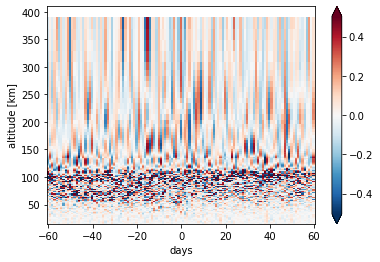

In [138]:
sea_gw_v_kir_gaia_anomalie.plot(x='days',robust=True)

##### Total kinetic energy of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


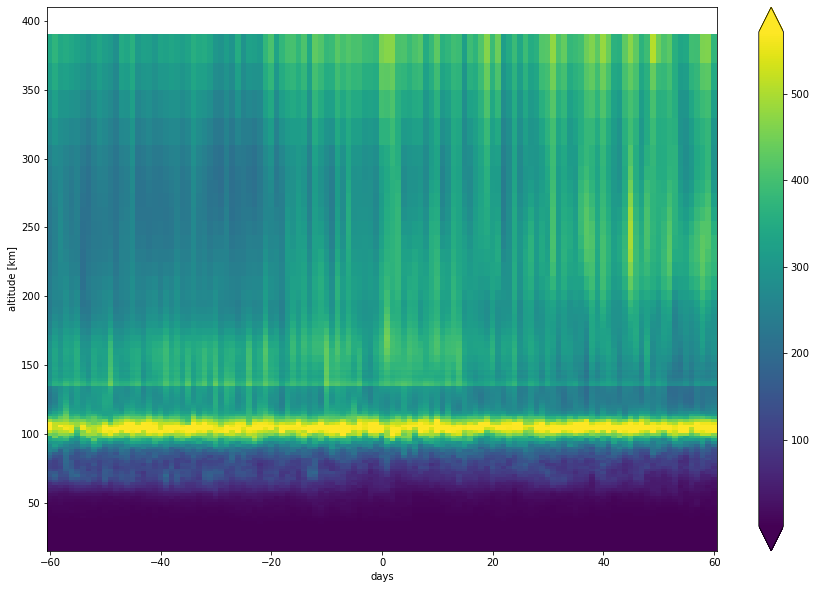

In [139]:
sea_gw_total_energy_kir_gaia.plot(x='days',size=10,robust=True)

##### Anomalies of the total kinetic energy of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


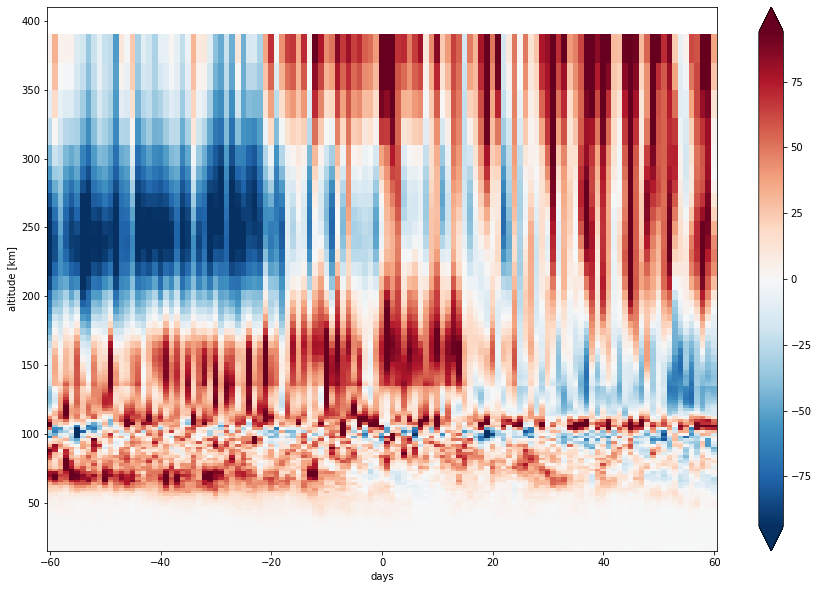

In [140]:
sea_gw_total_energy_kir_gaia_anomalie.plot(x='days',size=10,robust=True)